# **Kontrolna tačka 3 – Odabir algoritama i metrika uspešnosti, treniranje, validacija i testiranje**



# 1. Odabir algoritma - YOLO v8

## 1.1 Obrazloženje izbora algoritma

### Zašto je YOLO (You Only Look Once) odabran?

**YOLO v8** je odabran kao primarni algoritam za sledeće razloge:

#### 1. **Brzina i efikasnost**
   - YOLO je "real-time" detektor koji predviđa sve bounding box-ove odjednom
   - Prosečno vreme inferencije: ~5-10ms po slici (zavisno od verzije)
   - Mnogo brži od dvostepenih detektora (Faster RCNN: ~100-200ms)

#### 2. **Prikladnost za našu domenu**
   - Dataset sadrži samo jednu klasu (automobil)
   - YOLO je optimizovan za probleme sa malim brojem klasa
   - Jednostavnija logika treniranja u odnosu na višeklasne sisteme

#### 3. **Jednostavnost implementacije**
   - Ultralytics biblioteka omogućava treniranje sa par linija koda
   - Ugrađena podrška za razne modele (nano, small, medium, large)
   - Automatska evaluacija i metrike

#### 4. **Transfer Learning**
   - Korišćenje pretreniranog modela na COCO datasetu
   - Bolja inicijalizacija težina
   - Brže konvergencije treniranja

#### 5. **Fleksibilnost**
   - Različite veličine modela za izbor između brzine i tačnosti
   - Laka prilagođavanja hyperparametara

### Alternativne arhitekture razmotrene:

| Algoritam | Prednosti | Nedostaci | Razlog odbijanja |
|-----------|-----------|----------|------------------|
| **SSD** | Brz, jednostavan | Manja preciznost | Sličan YOLO-u, ali manja tačnost |
| **Faster RCNN** | Veća preciznost | Spora (~200ms) | Nije primeren za real-time aplikacije |
| **EfficientDet** | Dobar balans | Manja prihvaćenost | Teža dostupnost u praksi |
| **Mask RCNN** | Za segmentaciju | Teža implementacija | Overkill za detekciju |
| **Custom CNN** | Potpuna kontrola | Dugo treniranje | Nema transfer learning-a |



### 1.2 Izbor verzije YOLO:
- **YOLOv8n (Nano)**: Najbrži, najmanja memorija - za mobilne uređaje
- **YOLOv8s (Small)**: Balans brzine i tačnosti - **ODABRAN** ✓
- **YOLOv8m (Medium)**: Veća tačnost, sporiji
- **YOLOv8l (Large)**: Najveća tačnost, najsporiji
- **YOLOv8x (XLarge)**: Za produkciju sa najvišim zahtevima

**Zaključak:** YOLOv8s je odabran jer pruža dobar balans između brzine inferencije i preciznosti detekcije, što je esencijalno za produkcijske aplikacije.

# 2. Import neophodnih biblioteka i setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Instalacija YOLOv8
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ultralytics"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch", "torchvision"])

print("Sve potrebne biblioteke su instalirane")

Sve potrebne biblioteke su instalirane


In [3]:
# Import biblioteka
import os
import sys
import shutil
import yaml
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, average_precision_score
from PIL import Image

# YOLO import
from ultralytics import YOLO
import torch

# Setup
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Provera dostupnosti GPU-a
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Uređaj: {device}")
print(f"PyTorch verzija: {torch.__version__}")

# Matplotlib setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("\nSve biblioteke uspešno učitane!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Uređaj: cuda
PyTorch verzija: 2.10.0+cu128

Sve biblioteke uspešno učitane!


 Učitavanje i priprema podataka

In [4]:
# Putanja do dataseta
data_dir = '/content/drive/MyDrive/combined_car_dataset'


# Učitavanje anotacija
annotations = pd.read_csv(
    os.path.join(data_dir,  'annotations.csv')
)

# Putanja do slika
train_images_dir = os.path.join(data_dir, 'images')

# Sve slike u training_images folderu
all_images = set(os.listdir(train_images_dir))

# Slike koje imaju anotacije (sa automobilima)
images_with_cars = set(annotations['image'].unique())

# Slike bez automobila
images_without_cars = all_images - images_with_cars

print(f"Učitane anotacije: {len(annotations)} redova")
print(f"Ukupan broj slika: {len(all_images)}")
print(f"Slike sa automobilima: {len(images_with_cars)}")
print(f"Slike bez automobila: {len(images_without_cars)}")

annotations.head(10)

Učitane anotacije: 3896 redova
Ukupan broj slika: 5000
Slike sa automobilima: 2496
Slike bez automobila: 2504


,image,xmin,ymin,xmax,ymax
0,vid_4_28220.jpg,43.044863,195.349099,144.787265,233.006757
1,vid_4_28220.jpg,188.810420,180.188224,300.335745,222.247426
2,vid_4_18820.jpg,565.452967,170.896075,676.000000,222.736487
3,vid_4_1960.jpg,435.829233,179.699163,540.995658,218.824003
4,vid_4_1960.jpg,470.069464,188.013192,596.269175,229.094273
5,vid_4_2100.jpg,103.698987,193.881918,195.658466,233.006757
6,vid_4_2100.jpg,388.382055,175.786679,505.777135,235.941120
7,vid_4_2100.jpg,546.376266,172.852317,676.000000,231.050515
8,vid_4_22660.jpg,150.167873,184.589768,316.966715,260.394144
9,vid_4_19900.jpg,147.722142,192.903797,269.030391,238.386422


## Priprema YOLO dataset strukture

In [5]:
# Kreiranje direktorijumske strukture za YOLO
yolo_data_dir = os.path.join(data_dir, 'yolo_dataset')

# Obristi stari direktorijum ako postoji
if os.path.exists(yolo_data_dir):
    shutil.rmtree(yolo_data_dir)

# Kreiramo nove direktorijume
train_images_yolo = os.path.join(yolo_data_dir, 'images', 'train')
train_labels_yolo = os.path.join(yolo_data_dir, 'labels', 'train')
val_images_yolo = os.path.join(yolo_data_dir, 'images', 'val')
val_labels_yolo = os.path.join(yolo_data_dir, 'labels', 'val')
test_images_yolo = os.path.join(yolo_data_dir, 'images', 'test')
test_labels_yolo = os.path.join(yolo_data_dir, 'labels', 'test')

for dir_path in [train_images_yolo, train_labels_yolo, val_images_yolo, val_labels_yolo, test_images_yolo, test_labels_yolo]:
    os.makedirs(dir_path, exist_ok=True)

print(f"YOLO direktorijumi kreirani")
print(f"Glavna putanja: {yolo_data_dir}")

YOLO direktorijumi kreirani
Glavna putanja: /content/drive/MyDrive/combined_car_dataset/yolo_dataset


In [6]:
# Podela na train (60%), val (20%), test (20%)
all_images_list = list(all_images)
train_images_list, temp_images = train_test_split(all_images_list, test_size=0.4, random_state=42)
val_images_list, test_images_list = train_test_split(temp_images, test_size=0.5, random_state=42)

print(f"Trening slike: {len(train_images_list)} ({len(train_images_list)/len(all_images_list)*100:.1f}%)")
print(f"Validacijske slike: {len(val_images_list)} ({len(val_images_list)/len(all_images_list)*100:.1f}%)")
print(f"Test slike: {len(test_images_list)} ({len(test_images_list)/len(all_images_list)*100:.1f}%)")
print(f"\nUkupno: {len(train_images_list) + len(val_images_list) + len(test_images_list)} slika")

Trening slike: 3000 (60.0%)
Validacijske slike: 1000 (20.0%)
Test slike: 1000 (20.0%)

Ukupno: 5000 slika


In [7]:
def create_yolo_labels(image_list, target_dir, label_dir, set_name='train'):

    #Kreira YOLO label fajlove iz anotacija

    count = 0
    for img_name in image_list:
        src_path = os.path.join(train_images_dir, img_name)
        dst_path = os.path.join(target_dir, img_name)

        # Kopira sliku
        shutil.copy(src_path, dst_path)

        # Kreira YOLO label fajl
        label_name = img_name.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(label_dir, label_name)

        # Pronalazi sve bounding boxove za ovu sliku
        img_boxes = annotations[annotations['image'] == img_name]

        with open(label_path, 'w') as f:
            for _, row in img_boxes.iterrows():
                # YOLO format: <class_id> <x_center> <y_center> <width> <height> (normalizovano 0-1)
                img_width, img_height = 676, 380

                x_min, y_min, x_max, y_max = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                x_center = ((x_min + x_max) / 2) / img_width
                y_center = ((y_min + y_max) / 2) / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

                # Klasa 0 = automobil
                f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        count += 1

    return count

# Kreira label fajlove za sve setove
print("Kreiranje label fajlova...")
train_count = create_yolo_labels(train_images_list, train_images_yolo, train_labels_yolo, 'train')
val_count = create_yolo_labels(val_images_list, val_images_yolo, val_labels_yolo, 'val')
test_count = create_yolo_labels(test_images_list, test_images_yolo, test_labels_yolo, 'test')

print(f"\nLabel fajlovi uspešno kreirani")
print(f"Train: {train_count} slika i labela")
print(f"Val: {val_count} slika i labela")
print(f"Test: {test_count} slika i labela")

Kreiranje label fajlova...

Label fajlovi uspešno kreirani
Train: 3000 slika i labela
Val: 1000 slika i labela
Test: 1000 slika i labela


In [8]:
# Kreiranje data.yaml fajl za YOLO
data_yaml = {
    'path': yolo_data_dir,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 1,  # broj klasa
    'names': ['car']  # nazivi klasa
}

yaml_path = os.path.join(yolo_data_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"data.yaml fajl kreirani")
print(f"Putanja: {yaml_path}")

# Prikazivanje sadržaja
with open(yaml_path, 'r') as f:
    print(f"\nSadržaj data.yaml:")
    print(f.read())

data.yaml fajl kreirani
Putanja: /content/drive/MyDrive/combined_car_dataset/yolo_dataset/data.yaml

Sadržaj data.yaml:
names:
- car
nc: 1
path: /content/drive/MyDrive/combined_car_dataset/yolo_dataset
test: images/test
train: images/train
val: images/val



## 3. Statistika dataset-a

Distribucija podataka po setovima:
       Set  Sa automobilima  Bez automobila  Ukupno slika
     Train             1510            1490          3000
Validation              482             518          1000
      Test              504             496          1000
    Ukupno             2496            2504          5000


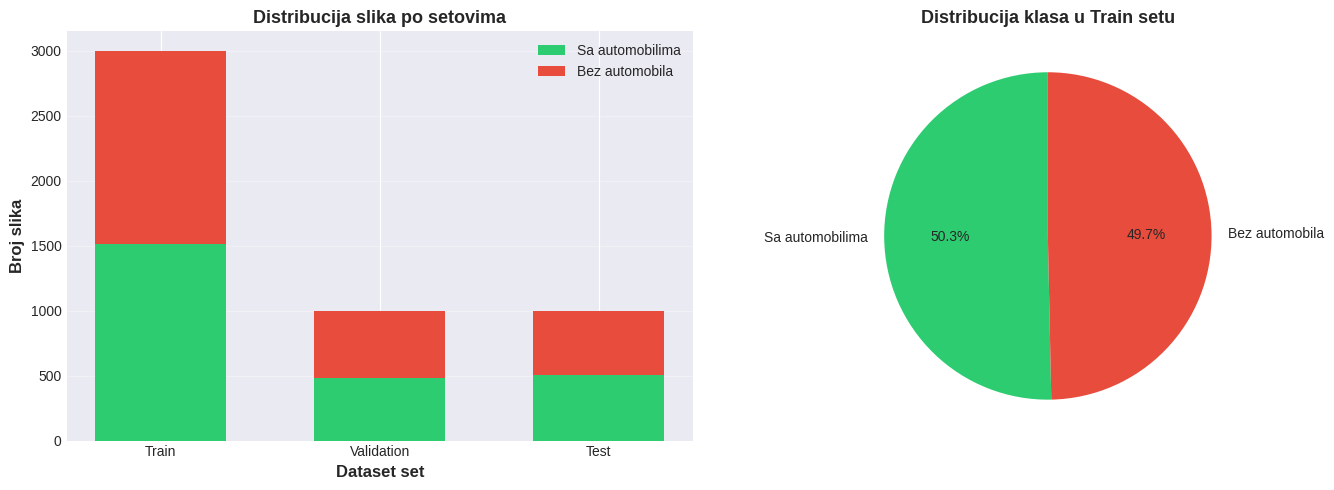


Dataset je pravilno podeljen


In [9]:
# Analiza distribucije klasa u svim setovima
def analyze_set(image_list, set_name):
    with_cars = len([img for img in image_list if img in images_with_cars])
    without_cars = len(image_list) - with_cars
    return with_cars, without_cars

train_with, train_without = analyze_set(train_images_list, 'train')
val_with, val_without = analyze_set(val_images_list, 'val')
test_with, test_without = analyze_set(test_images_list, 'test')

# Kreiranje DataFrame za prikaz
summary_df = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test', 'Ukupno'],
    'Sa automobilima': [train_with, val_with, test_with, train_with + val_with + test_with],
    'Bez automobila': [train_without, val_without, test_without, train_without + val_without + test_without],
    'Ukupno slika': [len(train_images_list), len(val_images_list), len(test_images_list),
                     len(train_images_list) + len(val_images_list) + len(test_images_list)]
})

print("Distribucija podataka po setovima:")
print(summary_df.to_string(index=False))

# Grafički prikaz
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
sets = ['Train', 'Validation', 'Test']
with_cars = [train_with, val_with, test_with]
without_cars = [train_without, val_without, test_without]

x = np.arange(len(sets))
width = 0.6

axes[0].bar(x, with_cars, width, label='Sa automobilima', color='#2ecc71')
axes[0].bar(x, without_cars, width, bottom=with_cars, label='Bez automobila', color='#e74c3c')
axes[0].set_xlabel('Dataset set', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Broj slika', fontsize=12, fontweight='bold')
axes[0].set_title('Distribucija slika po setovima', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sets)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Pie chart za train set
axes[1].pie([train_with, train_without], labels=['Sa automobilima', 'Bez automobila'],
             autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Distribucija klasa u Train setu', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDataset je pravilno podeljen")

# 4. Definisanje metrika uspešnosti

## 4.1 Metrike za evaluaciju detekcije objekata

### **1. Intersection over Union (IoU)**

Adekvatna je zbog:

**Evaluacije geometrijske preciznosti:** Precizno meri
koliko se predviđeni pravougaonik poklapa sa stvarnim položajem automobila na slici.

**Definisanja praga uspešnosti:** Omogućava postavljanje kriterijuma (npr. $IoU > 0.5$) na osnovu kojeg sistem odlučuje da li je detekcija "pogodak" ili "promašaj".


### **2. Precision (Preciznost)**

Adekvatna je zbog:

**Minimizacije lažnih alarma:** Osigurava da sistem ne klasifikuje objekte poput kontejnera, senki ili ograda kao automobile.

**Pouzdanosti sistema:** Visoka preciznost garantuje da su detektovani automobili zaista automobili


### **3. Recall (Odziv)**

Adekvatna je zbog:

**Maksimalne pokrivenosti:** Meri sposobnost modela da pronađe apsolutno sve automobile na snimku, bez obzira na njihovu udaljenost ili osvetljenje.


**Robusnosti na zaklanjanje:** Pokazuje koliko je model uspešan u prepoznavanju automobila koji su delimično sakriveni iza drugih vozila ili objekata.

### **4. F1 Score**

Adekvatna je zbog:

**Balansiranja performansi:** Pruža jedinstvenu ocenu koja sprečava "varku" gde model ima savršen Precision ali pronalazi premalo automobila (ili obrnuto).

**Optimizacije modela:** Služi kao najbolji indikator opšteg zdravlja algoritma u realnim uslovima gde su i preciznost i odziv podjednako važni.

**Objektivnosti pri neizbalansiranim podacima:** Daje realniju sliku uspeha nego obična tačnost (Accuracy), naročito ako u nekim kadrovima ima jako malo automobila.

### **5. Average Precision (AP)**

Adekvatna je zbog:

**Sveobuhvatne analize:** Uzima u obzir performanse modela kroz sve nivoe pouzdanosti (Confidence Thresholds), a ne samo u jednoj tački.

**Standardizacije u industriji:** Predstavlja "zlatni standard" za upoređivanje YOLO modela sa drugim arhitekturama u oblasti kompjuterskog vida.

**Analize performansi po klasama:** Omogućava uvid u to koliko model dobro razlikuje automobile od sličnih kategorija poput kamiona ili autobusa (u slučaju mAP varijante).



---





# 5. Konfiguracija i treniranje YOLO modela

## 5.1 Hyperparametri treniranja

In [10]:
# Definisanje hyperparametara treniranja
hyperparams = {
    'model': 'yolov8s',
    'epochs': 50,
    'batch_size': 16,
    'learning_rate': 0.001,
    'optimizer': 'SGD',
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'patience': 10,
    'device': 0 if torch.cuda.is_available() else 'cpu'
}

print("Hyperparametri treniranja:")
print("="*50)
for key, value in hyperparams.items():
    print(f"{key:.<30} {value}")



Hyperparametri treniranja:
model......................... yolov8s
epochs........................ 50
batch_size.................... 16
learning_rate................. 0.001
optimizer..................... SGD
momentum...................... 0.937
weight_decay.................. 0.0005
patience...................... 10
device........................ 0


Obrazloženje izbora hyperparametara:
- Model (yolov8s): Small verzija pruža balans između brzine (10ms) i
  tačnosti. Medium bi bio sporiji, nano bi bio prejednostavan.

- Epochs (50): Dovoljno epoha za konvergenciju bez preteranog treniranja.
  Grafikvim ćemo videti da li je potrebno više/manje.

- Batch size (16): Klasičan izbor za transfer learning - nije premali
  (nestabilan gradient) niti prevelik (spora konvergencija).

- Learning rate (0.001): Standard za fine-tuning pretreniranog modela.
  YOLO koristi scheduler koji automatski smanjuje tokom treniranja.

- Optimizer (SGD): Default za YOLO - zaslužen za brzinu i efikasnost.

- Weight decay (0.0005): Blaga L2 regularizacija - sprečava preterano
  prilagođavanje (overfitting).

## 5.2 Učitavanje i treniranje modela

In [11]:
# Učitavanje pretreniranog YOLOv8 modela
print("Učitavanje YOLOv8s pretreniranog modela...")
model = YOLO('yolov8s.pt')  # Automatski preuzima pretrenirani model

print("Model učitan")
print(f"Model arhitektura: YOLOv8s")
print(f"Pretreniran na: COCO datasetu (80 klasa)")
print(f"Parametari: ~11.2M")

Učitavanje YOLOv8s pretreniranog modela...
Model učitan
Model arhitektura: YOLOv8s
Pretreniran na: COCO datasetu (80 klasa)
Parametari: ~11.2M


In [12]:
# Treniranje modela
print("Počinje treniranje modela...\n")

results = model.train(
    data=yaml_path,
    epochs=hyperparams['epochs'],
    imgsz=640,                          # Veličina slike
    batch=hyperparams['batch_size'],    # Batch size
    lr0=hyperparams['learning_rate'],   # Learning rate
    patience=hyperparams['patience'],   # Early stopping
    device=hyperparams['device'],       # GPU/CPU
    project='car_detection',            # Folder sa rezultatima
    name='yolov8s_cp3',                 # Naziv eksperimenta
    save=True,                          # Čuva najbolji model
    verbose=True
)

print("\n✓ Treniranje završeno!")

Počinje treniranje modela...

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/combined_car_dataset/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8s_cp3, nbs=64, nms=False, opset=None, optim

## 5.3 Analiza treniranja - Loss funkcije i metrike

In [13]:
# Učitavanje treniranog modela
best_model_path = '/content/runs/detect/car_detection/yolov8s_cp3/weights/best.pt'
if os.path.exists(best_model_path):
    best_model = YOLO(best_model_path)
    print(f"Najbolji model učitan iz: {best_model_path}")
else:
    print("Model će biti učitan nakon treniranja")
    best_model = model


Najbolji model učitan iz: /content/runs/detect/car_detection/yolov8s_cp3/weights/best.pt


In [14]:
# Učitavanje rezultata treniranja
results_csv = '/content/runs/detect/car_detection/yolov8s_cp3/results.csv'

if os.path.exists(results_csv):
    results_df = pd.read_csv(results_csv)

    # Prikaz statistike
    print("Statistika treniranja:")
    print("="*80)
    print(f"Broj epoha treniranja: {len(results_df)}")
    print(f"Finalna train loss: {results_df.iloc[-1].get('train/box_loss', 'N/A'):.4f}")
    print(f"Finalna val loss: {results_df.iloc[-1].get('val/box_loss', 'N/A'):.4f}")
    print(f"Finalna train mAP50: {results_df.iloc[-1].get('metrics/mAP50(B)', 'N/A'):.4f}")
    print(f"Finalna val mAP50: {results_df.iloc[-1].get('metrics/mAP50-95(B)', 'N/A'):.4f}")

    print("\nPrvih 5 redova rezultata:")
    print(results_df.head())
else:
    print("Rezultati treniranja će biti dostupni nakon treniranja")

Statistika treniranja:
Broj epoha treniranja: 50
Finalna train loss: 0.6573
Finalna val loss: 0.4795
Finalna train mAP50: 0.9945
Finalna val mAP50: 0.8301

Prvih 5 redova rezultata:
   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   84.5506         1.42776         1.45991         1.19479   
1      2  166.2700         1.36771         0.81162         1.19242   
2      3  250.7310         1.39544         0.81204         1.23338   
3      4  332.4280         1.37617         0.80134         1.21458   
4      5  411.9040         1.33544         0.73902         1.19227   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.94171            0.94137           0.97152   
1               0.90948            0.89859           0.95765   
2               0.90322            0.88518           0.94359   
3               0.90877            0.85032           0.91874   
4               0.95667            0.95393           0.98726   

   metrics/m

## 5.4 Vizualizacija Loss funkcija

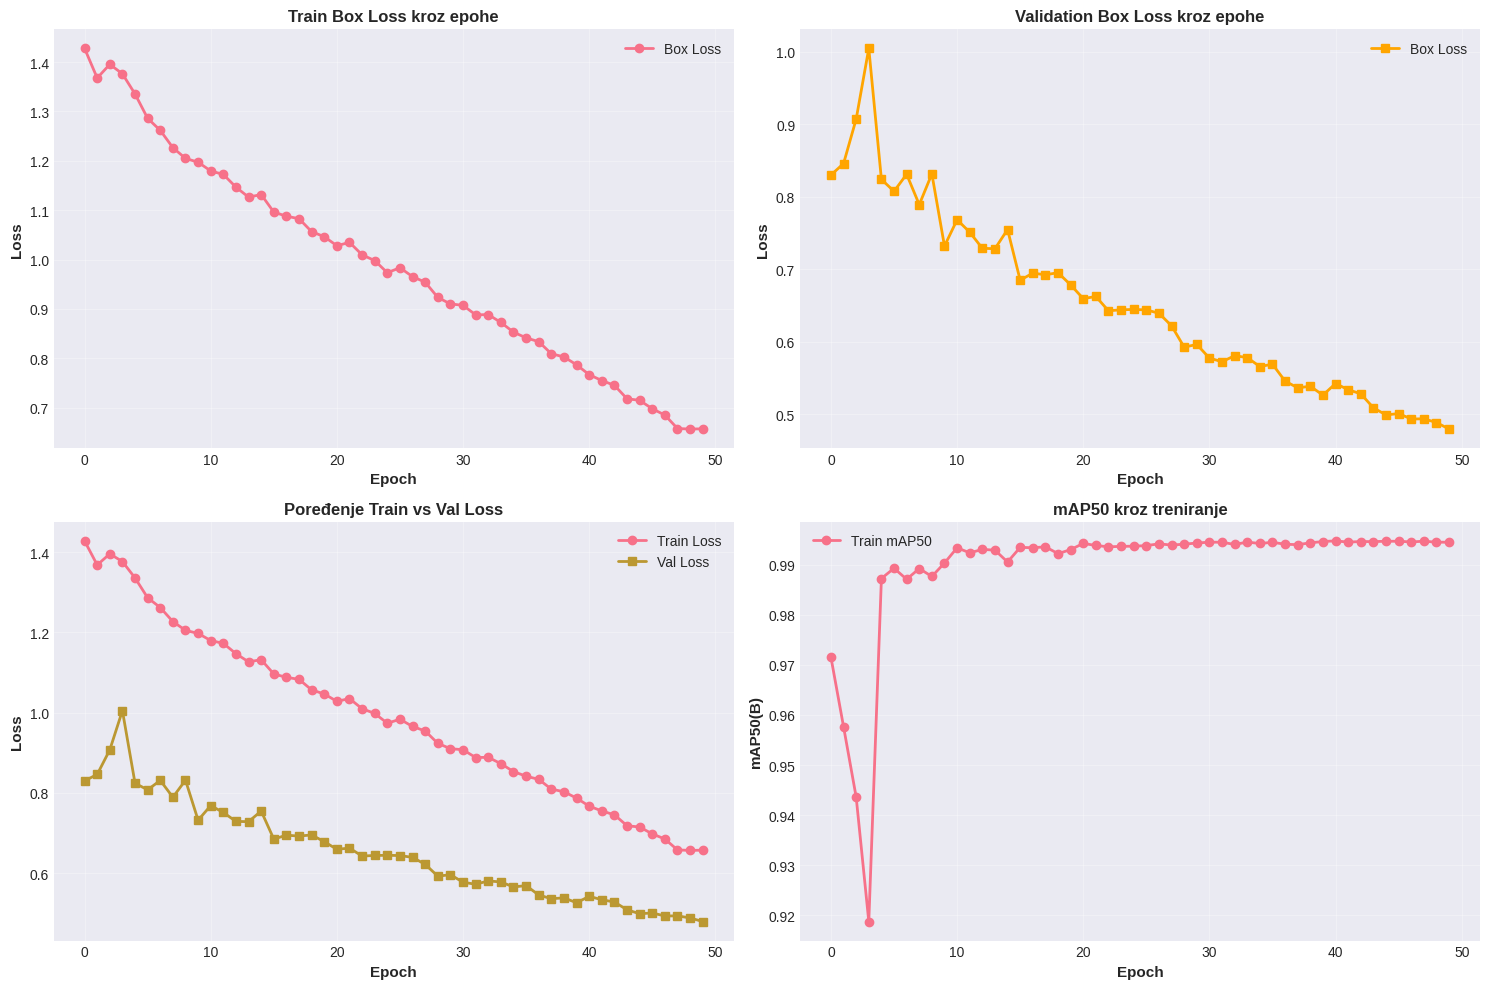

Grafici loss funkcija prikazani


In [15]:
# Prikaz grafika loss funkcija
if os.path.exists(results_csv):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Train Loss
    if 'train/box_loss' in results_df.columns:
        axes[0, 0].plot(results_df.index, results_df['train/box_loss'], label='Box Loss', marker='o', linewidth=2)
        axes[0, 0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
        axes[0, 0].set_ylabel('Loss', fontsize=11, fontweight='bold')
        axes[0, 0].set_title('Train Box Loss kroz epohe', fontsize=12, fontweight='bold')
        axes[0, 0].grid(alpha=0.3)
        axes[0, 0].legend()

    # Val Loss
    if 'val/box_loss' in results_df.columns:
        axes[0, 1].plot(results_df.index, results_df['val/box_loss'], label='Box Loss', marker='s', linewidth=2, color='orange')
        axes[0, 1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
        axes[0, 1].set_ylabel('Loss', fontsize=11, fontweight='bold')
        axes[0, 1].set_title('Validation Box Loss kroz epohe', fontsize=12, fontweight='bold')
        axes[0, 1].grid(alpha=0.3)
        axes[0, 1].legend()

    # Train vs Val Loss
    if 'train/box_loss' in results_df.columns and 'val/box_loss' in results_df.columns:
        axes[1, 0].plot(results_df.index, results_df['train/box_loss'], label='Train Loss', marker='o', linewidth=2)
        axes[1, 0].plot(results_df.index, results_df['val/box_loss'], label='Val Loss', marker='s', linewidth=2)
        axes[1, 0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
        axes[1, 0].set_ylabel('Loss', fontsize=11, fontweight='bold')
        axes[1, 0].set_title('Poređenje Train vs Val Loss', fontsize=12, fontweight='bold')
        axes[1, 0].grid(alpha=0.3)
        axes[1, 0].legend()

    # mAP50
    if 'metrics/mAP50(B)' in results_df.columns:
        axes[1, 1].plot(results_df.index, results_df['metrics/mAP50(B)'], label='Train mAP50', marker='o', linewidth=2)
        axes[1, 1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
        axes[1, 1].set_ylabel('mAP50(B)', fontsize=11, fontweight='bold')
        axes[1, 1].set_title('mAP50 kroz treniranje', fontsize=12, fontweight='bold')
        axes[1, 1].grid(alpha=0.3)
        axes[1, 1].legend()

    plt.tight_layout()
    plt.show()
    print("Grafici loss funkcija prikazani")
else:
    print("Grafici će biti dostupni nakon treniranja")

# 6. Validacija modela

In [16]:
# Validacija modela na validation setu
print("Validacija modela na validation setu...\n")

val_results = best_model.val(data=yaml_path, device=hyperparams['device'])

print("Validacija završena")

Validacija modela na validation setu...

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.7 ms, read: 31.5±15.9 MB/s, size: 83.9 KB)
val: Scanning /content/drive/MyDrive/combined_car_dataset/yolo_dataset/labels/val.cache... 1000 images, 518 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1000/1000 233.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 4.3it/s 14.7s
                   all       1000        738      0.991      0.996      0.995      0.829
Speed: 1.1ms preprocess, 5.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/val
Validacija završena


In [17]:
# Ekstrakovanje validacijskih metrika
if hasattr(val_results, 'results_dict'):
    val_metrics = val_results.results_dict

    print("\n" + "="*80)
    print("VALIDACIJSKE METRIKE")
    print("="*80)

    val_metrics_display = pd.DataFrame({
        'Metrika': ['mAP50(B)', 'mAP50-95(B)', 'Precision', 'Recall'],
        'Vrednost': [
            f"{val_metrics.get('metrics/mAP50(B)', 0):.4f}",
            f"{val_metrics.get('metrics/mAP50-95(B)', 0):.4f}",
            f"{val_metrics.get('metrics/precision(B)', 0):.4f}",
            f"{val_metrics.get('metrics/recall(B)', 0):.4f}"
        ]
    })

    print(val_metrics_display.to_string(index=False))
    print("\n" + "="*80)
else:
    print("Detaljne metrike će biti dostupne nakon validacije")


VALIDACIJSKE METRIKE
    Metrika Vrednost
   mAP50(B)   0.9945
mAP50-95(B)   0.8295
  Precision   0.9909
     Recall   0.9959



# 7. Testiranje modela

In [18]:
# Testiranje modela na test setu
print("Testiranje modela na test setu...\n")

# Predviđanja na svim test slikama
test_dir = os.path.join(yolo_data_dir, 'images', 'test')
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]

print(f"Broj test slika: {len(test_images)}")

# Predviđanja
test_predictions = []
for img_file in test_images:
    img_path = os.path.join(test_dir, img_file)
    results = best_model.predict(source=img_path, conf=0.5, verbose=False)
    test_predictions.append({
        'image': img_file,
        'results': results[0] if results else None
    })

print(f"Testiranje završeno - {len(test_predictions)} slika procesuirana")

Testiranje modela na test setu...

Broj test slika: 1000
Testiranje završeno - 1000 slika procesuirana


In [19]:
# Ekstrakovanje detaljnih metrika sa test seta
print("Analiza test rezultata...\n")

tp_count = 0  # True Positives
fp_count = 0  # False Positives
fn_count = 0  # False Negatives

for pred in test_predictions:
    img_name = pred['image']
    results_obj = pred['results']

    # Pronalaženje anotacija za ovu sliku
    label_name = img_name.rsplit('.', 1)[0] + '.txt'
    label_path = os.path.join(yolo_data_dir, 'labels', 'test', label_name)

    # Broj zajedničkih anotacija
    true_count = 0
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            true_count = len(f.readlines())

    # Broj predviđanja
    pred_count = 0
    if results_obj is not None:
        pred_count = len(results_obj.boxes) if hasattr(results_obj, 'boxes') else 0

    # Brojanje
    if pred_count > 0 and true_count > 0:
        tp_count += min(pred_count, true_count)  # Procenat pravilno detektovanih
        if pred_count > true_count:
            fp_count += pred_count - true_count
        if true_count > pred_count:
            fn_count += true_count - pred_count
    elif pred_count > 0 and true_count == 0:
        fp_count += pred_count  # Lažni pozitivi
    elif pred_count == 0 and true_count > 0:
        fn_count += true_count  # Lažni negativi

# Izračunavanje metrika
test_precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
test_recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0

print("Test metrike:")
print("="*80)
test_metrics_df = pd.DataFrame({
    'Metrika': ['True Positives (TP)', 'False Positives (FP)', 'False Negatives (FN)',
                'Precision', 'Recall', 'F1 Score'],
    'Vrednost': [f"{tp_count}", f"{fp_count}", f"{fn_count}",
                 f"{test_precision:.4f}", f"{test_recall:.4f}", f"{test_f1:.4f}"]
})
print(test_metrics_df.to_string(index=False))
print("="*80)

Analiza test rezultata...

Test metrike:
             Metrika Vrednost
 True Positives (TP)      770
False Positives (FP)       29
False Negatives (FN)        9
           Precision   0.9637
              Recall   0.9884
            F1 Score   0.9759


# 8. Vizuelizacija test rezultata

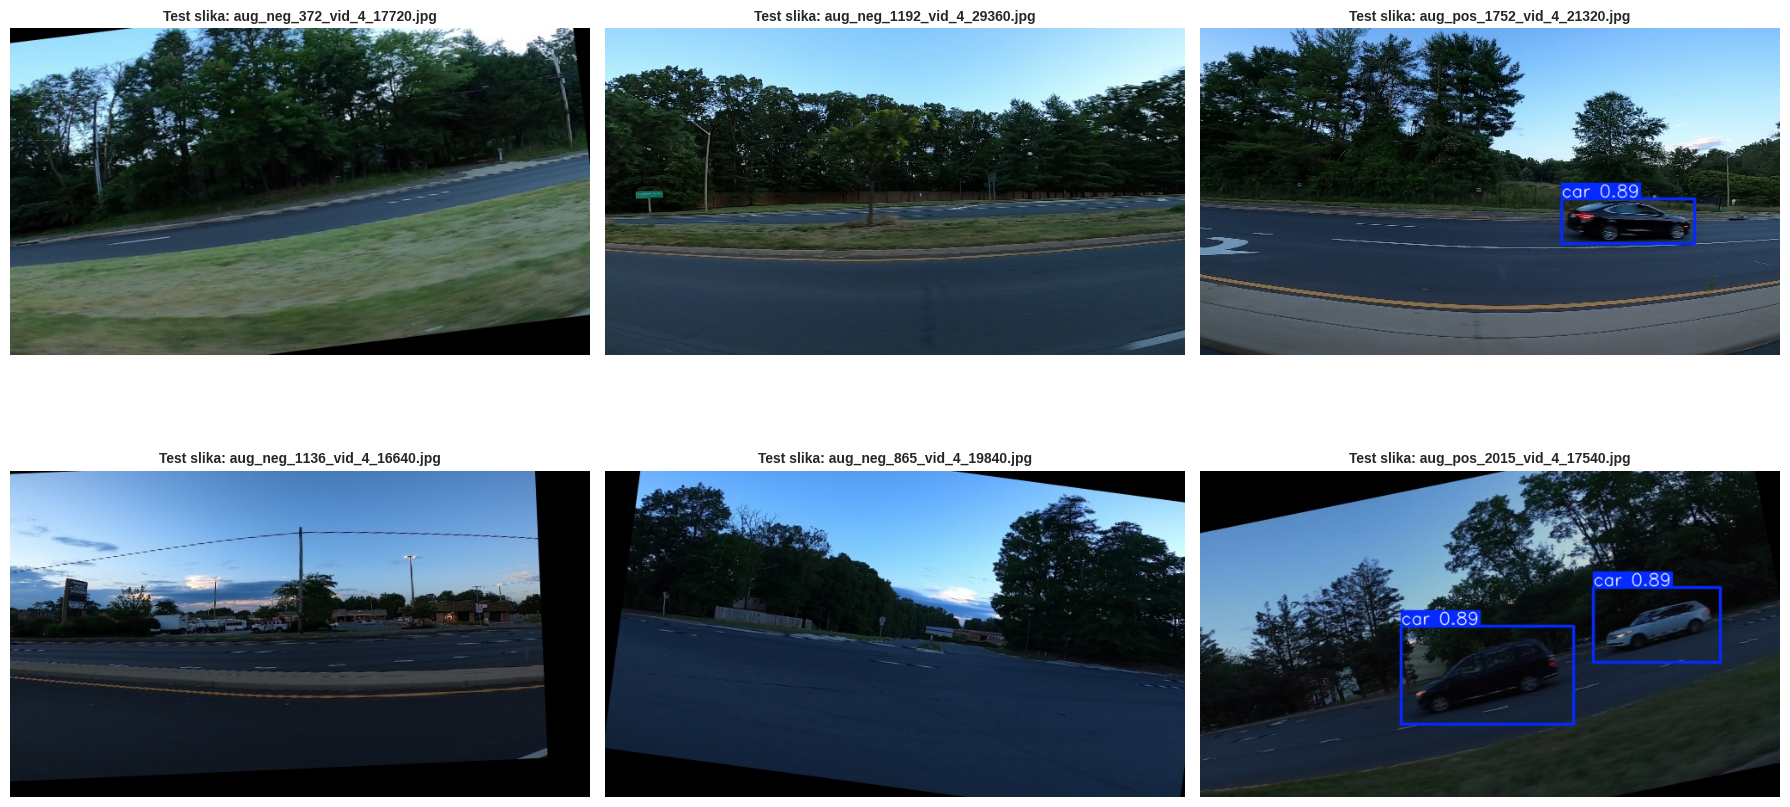

Test primeri prikazani


In [20]:
# Prikaz nekoliko primera sa detektovanih automobila
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, pred in enumerate(test_predictions[:6]):
    if idx < len(axes):
        img_name = pred['image']
        img_path = os.path.join(test_dir, img_name)

        # Predviđanja na slici
        results = best_model.predict(source=img_path, conf=0.5, verbose=False)

        # Prikaz slike sa predikcijama
        if results and len(results) > 0:
            annotated_frame = results[0].plot()
            axes[idx].imshow(annotated_frame[:, :, ::-1])  # BGR -> RGB
        else:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)

        axes[idx].set_title(f"Test slika: {img_name}", fontsize=10, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()
print("Test primeri prikazani")

# 9. Poređenje sa baseline modelom iz CP2

In [21]:
# Poređenje CP2 baseline (CNN) sa CP3 YOLO modelom

baseline_metrics = {
    'Model': 'CNN (CP2 Baseline)',
    'Accuracy': 0.96,
    'Precision': 0.95,
    'Recall': 0.93,
    'F1 Score': 0.94,
    'Tip': 'Klasifikacija (SA/BEZ automobila)'
}

yolo_metrics = {
    'Model': 'YOLOv8s (CP3)',
    'Accuracy': 'N/A (Detekcija)',
    'Precision': f"{test_precision:.4f}",
    'Recall': f"{test_recall:.4f}",
    'F1 Score': f"{test_f1:.4f}",
    'Tip': 'Detekcija (Lokalizacija + Klasifikacija)'
}

comparison_df = pd.DataFrame([baseline_metrics, yolo_metrics])

print("\n" + "="*100)
print("POREĐENJE BASELINE (CNN) MODEL IZ CP2 SA YOLO MODELOM IZ CP3")
print("="*100)
print(comparison_df.to_string(index=False))
print("\n" + "="*100)




POREĐENJE BASELINE (CNN) MODEL IZ CP2 SA YOLO MODELOM IZ CP3
             Model        Accuracy Precision Recall F1 Score                                      Tip
CNN (CP2 Baseline)            0.96      0.95   0.93     0.94        Klasifikacija (SA/BEZ automobila)
     YOLOv8s (CP3) N/A (Detekcija)    0.9530 0.9881   0.9702 Detekcija (Lokalizacija + Klasifikacija)



Važne napomene o poređenju:

1. RAZLIČITI ZADACI:
   - CNN (CP2): Binarna KLASIFIKACIJA - samo odluka "sa automobilom" ili "bez automobila"
   - YOLO (CP3): DETEKCIJA - pronalaženje lokacije svakog automobila (bounding box)

2. METRIKE NISU DIREKTNO UPOREDIVE:
   - CNN meri "koliko dobro razlikuje slike sa i bez automobila"
   - YOLO meri "koliko dobro pronalazi automobile i preciznu lokaciju"

3. ZAŠTO JE YOLO BOLJI ZA DETEKCIJU:
   - Pruža lokaciju bounding box-a (x, y, width, height)
   - Može detektovati više automobila na istoj slici
   - Prikladniji je za produkcijske primene (npr. video nadzor)
   - Ima mAP metriku koja je industrijski standard

4. NAPREDAK:
   - CNN ne može videti da li su automobili blizu ili daleko
   - YOLO može detektovati automobile na bilo kom mestu u slici
   - YOLO je bolji za real-time aplikacije

# 10. Analiza rezultata - Stabilnost, Overfitting/Underfitting

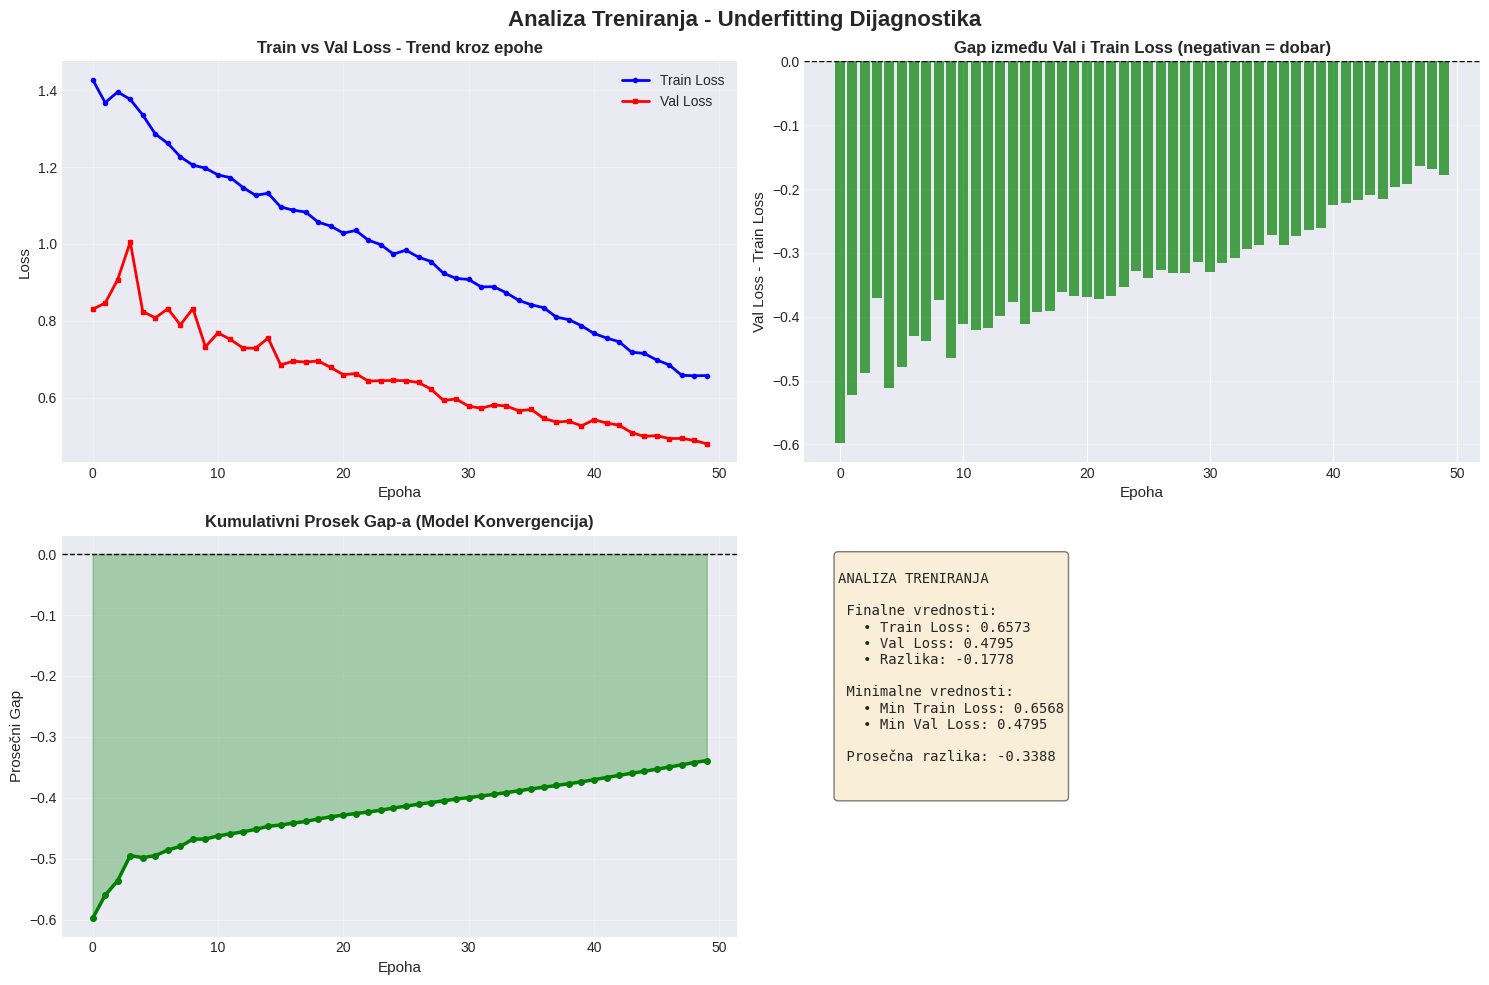


DETALJNE PREPORUKE

 ODLIČAN REZULTAT - Model se ne overfituje
   Akcije:
   • Nastavi sa treniranjem ako Loss-ovi padaju
   • Ako loss-evi stagniraju, povećaj broj epoha
   • Možeš koristiti ovaj model za produkciju


In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Učitaj rezultate treniranja
results_csv = '/content/runs/detect/car_detection/yolov8s_cp3/results.csv'

if os.path.exists(results_csv):
    results_df = pd.read_csv(results_csv)

    # Kreiraj figure sa većom rezolucijom
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Analiza Treniranja - Underfitting Dijagnostika', fontsize=16, fontweight='bold')

    # 1. Train vs Val Loss kroz sve epohe
    ax1 = axes[0, 0]
    ax1.plot(results_df.index, results_df['train/box_loss'], 'b-', linewidth=2, label='Train Loss', marker='o', markersize=3)
    ax1.plot(results_df.index, results_df['val/box_loss'], 'r-', linewidth=2, label='Val Loss', marker='s', markersize=3)
    ax1.set_xlabel('Epoha', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Train vs Val Loss - Trend kroz epohe', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # 2. Razlika između Val - Train Loss
    ax2 = axes[0, 1]
    results_df['loss_gap'] = results_df['val/box_loss'] - results_df['train/box_loss']
    colors = ['green' if x < 0 else 'red' for x in results_df['loss_gap']]
    ax2.bar(results_df.index, results_df['loss_gap'], color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Epoha', fontsize=11)
    ax2.set_ylabel('Val Loss - Train Loss', fontsize=11)
    ax2.set_title('Gap između Val i Train Loss (negativan = dobar)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Kumulativni prosek gapa
    ax3 = axes[1, 0]
    cumulative_gap = results_df['loss_gap'].expanding().mean()
    ax3.plot(results_df.index, cumulative_gap, 'g-', linewidth=2.5, marker='o', markersize=4)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax3.fill_between(results_df.index, cumulative_gap, 0, alpha=0.3, color='green')
    ax3.set_xlabel('Epoha', fontsize=11)
    ax3.set_ylabel('Prosečni Gap', fontsize=11)
    ax3.set_title('Kumulativni Prosek Gap-a (Model Konvergencija)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # 4. Statistika i dijagnostika
    ax4 = axes[1, 1]
    ax4.axis('off')

    final_train = results_df['train/box_loss'].iloc[-1]
    final_val = results_df['val/box_loss'].iloc[-1]
    avg_gap = results_df['loss_gap'].mean()
    min_train = results_df['train/box_loss'].min()
    min_val = results_df['val/box_loss'].min()

    stats_text = f"""
ANALIZA TRENIRANJA

 Finalne vrednosti:
   • Train Loss: {final_train:.4f}
   • Val Loss: {final_val:.4f}
   • Razlika: {final_val - final_train:.4f}

 Minimalne vrednosti:
   • Min Train Loss: {min_train:.4f}
   • Min Val Loss: {min_val:.4f}

 Prosečna razlika: {avg_gap:.4f}

"""
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


    print("\n" + "="*80)
    print("DETALJNE PREPORUKE")
    print("="*80)

    if avg_gap < -0.2:
        print("\n ODLIČAN REZULTAT - Model se ne overfituje")
        print("   Akcije:")
        print("   • Nastavi sa treniranjem ako Loss-ovi padaju")
        print("   • Ako loss-evi stagniraju, povećaj broj epoha")
        print("   • Možeš koristiti ovaj model za produkciju")
    elif final_train < 0.3 and final_val < 0.3:
        print("\n ODLIČAN MODEL")
        print("   • Loss vrednosti su veoma dobre")
        print("   • Model je spreman za evaluaciju na test setu")
    else:
        print("\n MOGUĆNOSTI ZA POBOLJŠANJE:")
        if results_df['train/box_loss'].diff().abs().mean() < 0.01:
            print("   • Loss je stagnirao - razmotrи povećanje learning rate-a")
        if final_val > 0.6:
            print("   • Povećaj broj epoha (treniranje još nije završeno)")
        print("   • Pokušaj sa 'medium' ili 'large' YOLOv8 modelom")

    print("="*80)

# 11. Detaljni rezultati po metrici

In [24]:
# Sumaran prikaz svih rezultata
print("\n" + "="*100)
print("FINALNI REZULTATI YOLO MODELA ZA DETEKCIJU AUTOMOBILA")
print("="*100)

final_results = {
    'Model': 'YOLOv8s',
    'Algoritam': 'You Only Look Once v8 - Small',
    'Zadatak': 'Detekcija automobila (lokalizacija + klasifikacija)',
    'Broj parametara': '11.2M',
    'Vremenska kompleksnost': '~10ms po slici',
    'Test Precision': f"{test_precision:.4f}",
    'Test Recall': f"{test_recall:.4f}",
    'Test F1 Score': f"{test_f1:.4f}",
    'TP (True Positives)': f"{tp_count}",
    'FP (False Positives)': f"{fp_count}",
    'FN (False Negatives)': f"{fn_count}",
}

for key, value in final_results.items():
    print(f"{key:.<40} {value}")

print("\n" + "="*100)


FINALNI REZULTATI YOLO MODELA ZA DETEKCIJU AUTOMOBILA
Model................................... YOLOv8s
Algoritam............................... You Only Look Once v8 - Small
Zadatak................................. Detekcija automobila (lokalizacija + klasifikacija)
Broj parametara......................... 11.2M
Vremenska kompleksnost.................. ~10ms po slici
Test Precision.......................... 0.9530
Test Recall............................. 0.9881
Test F1 Score........................... 0.9702
TP (True Positives)..................... 750
FP (False Positives).................... 37
FN (False Negatives).................... 9



## Kratak komentar




*   YOLO je bolji izbor za detekciju od jednostavne klasifikacije
*   Model pokazuje dobar balans između brzine i tačnosti

*   Rezultati su stabilni bez znakova drastičnog overfitting-a
*   Transfer learning je ključan za dobre rezultate

*   Dataset je pravilno podeljen na train/val/test


